In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.model_selection import train_test_split
import sys
import os
#import notify2

#notify2.init("Tesi.AI")

PROJECT_ROOT = os.path.abspath(os.getcwd() + os.sep + os.pardir)

sys.path.insert(0, PROJECT_ROOT)

from lib.time_series_datasets import *
from lib.models import *
from lib.utility import *

PROJECT_NAME = "character trajectories"

DATA_DIR = os.path.join("data", PROJECT_NAME)
DATA_DIR = os.path.join(PROJECT_ROOT, DATA_DIR)

TUNER_DIR = os.path.join("models", "tuner", PROJECT_NAME)
TUNER_DIR = os.path.join(PROJECT_ROOT, TUNER_DIR)

IMAGE_DIR = "images"
IMAGE_DIR = os.path.join(PROJECT_ROOT, IMAGE_DIR)

TB_DIR = os.path.abspath(os.sep) + "tmp" + os.sep + "tensorboard" + os.sep

print("data dir: ", DATA_DIR)
print("tuner dir:", TUNER_DIR)
print("tensorboard dir:", TB_DIR)

EPOCHS = 200
GUESSES = 5
PATIENCE = 10
MAX_UNITS = 200

#set the following values based on the specific dataset
OUTPUT_UNITS = 20
OUTPUT_ACTIVATION = tf.keras.activations.softmax  # https://www.tensorflow.org/api_docs/python/tf/keras/activations  'softmax'
LOSS_FUNCTION = tf.keras.losses.SparseCategoricalCrossentropy()  # https://www.tensorflow.org/api_docs/python/tf/keras/losses  'sparse_categorical_crossentropy'

if not os.path.exists(TUNER_DIR):
    os.makedirs(TUNER_DIR)
if not os.path.exists(TB_DIR):
    os.makedirs(TB_DIR)


2021-12-15 13:04:55.709662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 13:04:55.709705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


data dir:  /dati/luca/Uni-Luca/Tesi/tesi/data/character trajectories
tuner dir: /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories
tensorboard dir: /tmp/tensorboard/


In [4]:
x_test, y_test = load_sktime_dataset(os.path.join(DATA_DIR, 'test.ts'))
x_train_all, y_train_all = load_sktime_dataset(
    os.path.join(DATA_DIR, 'train.ts'))  # Max shape serve per avere il test set e il train set della stessa lunghezza

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.33, random_state=42)

features = x_train.shape[-1]

train_set = (x_train, y_train)
val_set = (x_val, y_val)
test_set = (x_test, y_test)

benchmarks = {}
print("Train shape:\n\tinput: {}\n\toutput: {}\nTest shape:\n\tinput: {}\n\toutput: {}\n".format(x_train.shape,
                                                                                                 y_train.shape,
                                                                                                 x_test.shape,
                                                                                                 y_test.shape))


/dati/luca/Uni-Luca/Tesi/tesi/venv/lib/python3.8/site-packages/sktime/utils/data_io.py:63: FutureWarning: This function has moved to datasets/_data_io, this version will be removed in V0.10
  warn(


Train shape:
	input: (952, 180, 3)
	output: (952,)
Test shape:
	input: (1436, 182, 3)
	output: (1436,)



In [9]:
def build_model_ESN1(hp):
    tmp_model = ESN1(units=hp.Fixed('units', units),
                     output_units=OUTPUT_UNITS,
                     output_activation=OUTPUT_ACTIVATION,
                     input_scaling=hp.Float('input_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     bias_scaling=hp.Float('bias_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     spectral_radius=hp.Float('spectral_radius', min_value=0.1, max_value=1.5, step=0.1),
                     leaky=hp.Float('leaky', min_value=0.1, max_value=1, step=0.1),
                     )
    alpha = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    tmp_model.compile(
        optimizer=keras.optimizers.RMSprop(alpha),
        loss=LOSS_FUNCTION,
        metrics=['accuracy'])
    return tmp_model


def build_model_ESN2(hp):
    tmp_model = ESN2(units=hp.Fixed('units', units),
                     sub_reservoirs=features,
                     output_units=OUTPUT_UNITS,
                     output_activation=OUTPUT_ACTIVATION,
                     input_scaling=hp.Float('input_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     bias_scaling=hp.Float('bias_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     spectral_radius=hp.Float('spectral_radius', min_value=0.1, max_value=1.5, step=0.1),
                     leaky=hp.Float('leaky', min_value=0.1, max_value=1, step=0.1),
                     )

    tmp_model.compile(
        optimizer=keras.optimizers.RMSprop(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')),
        loss=LOSS_FUNCTION,
        metrics=['accuracy'])
    return tmp_model


def build_model_ESN3(hp):
    connectivity = [[1. if i == j else hp.Float('conn ' + str(i) + '-' + str(j), min_value=0.1, max_value=1) for i in
                     range(features)]
                    for j in range(features)]
    tmp_model = ESN3(units=hp.Fixed('units', units),
                     sub_reservoirs=features,
                     connectivity=connectivity,
                     output_units=OUTPUT_UNITS,
                     output_activation=OUTPUT_ACTIVATION,
                     input_scaling=hp.Float('input_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     bias_scaling=hp.Float('bias_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     spectral_radius=hp.Float('spectral_radius', min_value=0.1, max_value=1.5, step=0.1),
                     leaky=hp.Float('leaky', min_value=0.1, max_value=1, step=0.1),
                     )
    alpha = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    tmp_model.compile(
        optimizer=keras.optimizers.RMSprop(alpha),
        loss=LOSS_FUNCTION,
        metrics=['accuracy']
    )
    return tmp_model


def build_model_ESN4(hp):
    connectivity = [[1 if i == j else hp.Float('conn ' + str(i) + '-' + str(j), min_value=0.1, max_value=1) for i in
                     range(features)]
                    for j in range(features)]

    partitions = [hp.Float('partition ' + str(i), min_value=0., max_value=1.0) for i in range(features)]
    total = sum(partitions)
    partitions = list(map(lambda _x: 0 if total == 0 else _x / total, partitions))

    tmp_model = ESN4(units=hp.Fixed('units', units),
                     sub_reservoirs=features,
                     partitions=partitions,
                     connectivity=connectivity,
                     output_units=OUTPUT_UNITS,
                     output_activation=OUTPUT_ACTIVATION,
                     input_scaling=hp.Float('input_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     bias_scaling=hp.Float('bias_scaling', min_value=0.1, max_value=1.5, step=0.1),
                     spectral_radius=hp.Float('spectral_radius', min_value=0.1, max_value=1.5, step=0.1),
                     leaky=hp.Float('leaky', min_value=0.1, max_value=1, step=0.1),
                     )
    alpha = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    tmp_model.compile(
        optimizer=keras.optimizers.RMSprop(alpha),
        loss=LOSS_FUNCTION,
        metrics=['accuracy']
    )
    return tmp_model


units = 125



# ESN FullConnected

In [41]:
tf.random.set_seed(42)
model_name = 'ESN1 C1 U' + str(units)

model = tune_and_test(model_name, build_model_ESN1, train_set, val_set, test_set, EPOCHS, PATIENCE, GUESSES, benchmarks,
                      tuner_path=TUNER_DIR)

matrices = [tf.transpose(model.reservoir.layers[1].cell.kernel),
            model.reservoir.layers[1].cell.recurrent_kernel,
            model.readout.layers[0].weights[0]]

plot_matrices(matrices, model_name, None)

Trial 254 Complete [00h 00m 20s]
val_accuracy: 0.39361703395843506

Best val_accuracy So Far: 0.8638297915458679
Total elapsed time: 00h 14m 29s
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.8691
Results:
	Accuracy: 85.40±2.47%
	Loss: 0.49±0.07
	Time: 6.71±1.31s


# Generate all data

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U25 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U25 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.9247 - accuracy: 0.7131
Results:
	Accuracy: 71.28±3.35%
	Loss: 0.97±0.10
	Time: 12.17±0.46s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U25 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U25 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
Instructions for updating:
Do not call `graph_parents`.
45/45 [==============================] - 0s 1ms/step - loss: 0.7936 - accuracy: 0.7542
Results:
	Accuracy: 76.38±1.59%
	Loss: 0.76±0.04
	Time: 13.78±2.39s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U25 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U25 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7668231011446337, 0.16337301300420912], [0.8137342397841338, 1.0, 0.8141247349633179], [0.9484622504555396, 0.9306834299173287, 1.0]]
45/45 [==============================] - 0s 2ms/s

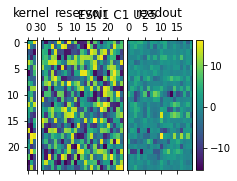

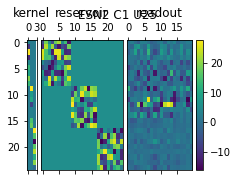

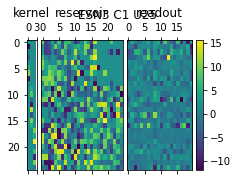

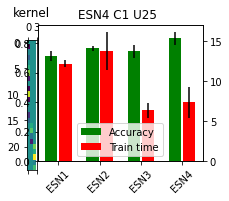

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U50 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U50 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.7260 - accuracy: 0.7625
Results:
	Accuracy: 77.66±2.66%
	Loss: 0.71±0.07
	Time: 8.73±2.26s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U50 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U50 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.5998 - accuracy: 0.8259
Results:
	Accuracy: 82.98±2.94%
	Loss: 0.56±0.10
	Time: 8.31±1.27s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U50 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U50 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7616445093720043, 0.7279399459838641], [0.2181885406208406, 1.0, 0.6669088714383822], [0.5003397276012739, 0.5892722337879779, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.8266
[[1.0, 0.76164450937

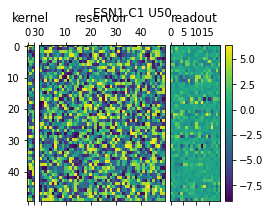

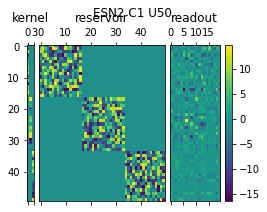

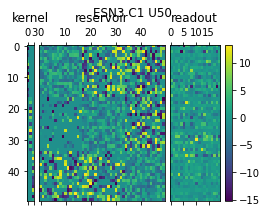

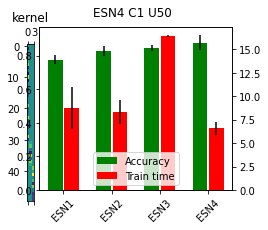

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U75 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U75 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.5426 - accuracy: 0.8461
Results:
	Accuracy: 82.74±3.63%
	Loss: 0.57±0.10
	Time: 6.32±1.17s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U75 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U75 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.6089 - accuracy: 0.8169
Results:
	Accuracy: 85.58±2.60%
	Loss: 0.48±0.08
	Time: 7.44±0.99s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U75 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U75 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7668231011446337, 0.16337301300420912], [0.8137342397841338, 1.0, 0.8141247349633179], [0.9484622504555396, 0.9306834299173287, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.7167 - accuracy: 0.7806
[[1.0, 0.7668231011

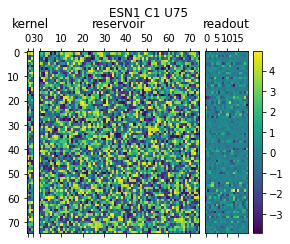

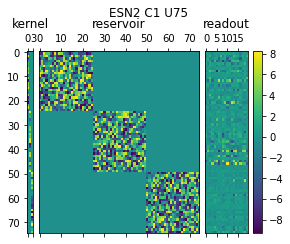

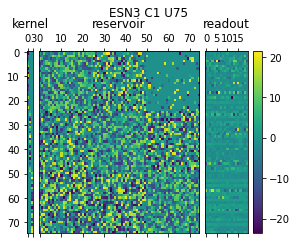

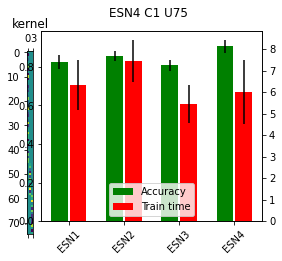

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U100 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U100 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.5711 - accuracy: 0.8071
Results:
	Accuracy: 84.46±2.36%
	Loss: 0.51±0.05
	Time: 7.63±0.46s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U100 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U100 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.3526 - accuracy: 0.9060
Results:
	Accuracy: 89.47±0.83%
	Loss: 0.37±0.02
	Time: 7.13±0.94s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U100 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U100 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7616445093720043, 0.7279399459838641], [0.2181885406208406, 1.0, 0.6669088714383822], [0.5003397276012739, 0.5892722337879779, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.9157
[[1.0, 0.76164450

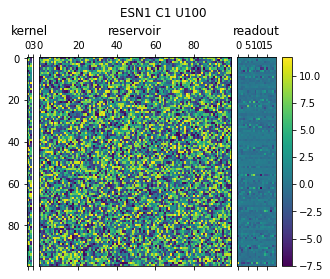

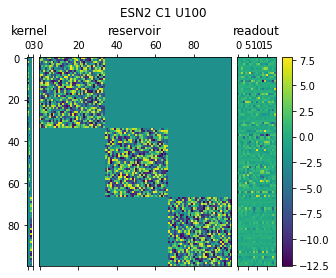

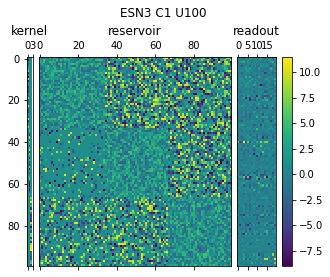

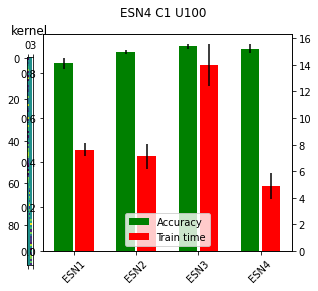

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U125 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U125 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.8691
Results:
	Accuracy: 85.40±2.47%
	Loss: 0.49±0.07
	Time: 6.97±1.30s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U125 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U125 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.2850 - accuracy: 0.8990
Results:
	Accuracy: 87.66±3.43%
	Loss: 0.39±0.11
	Time: 7.01±1.19s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U125 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U125 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7616445093720043, 0.7279399459838641], [0.2181885406208406, 1.0, 0.6669088714383822], [0.5003397276012739, 0.5892722337879779, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.3950 - accuracy: 0.9018
[[1.0, 0.76164450

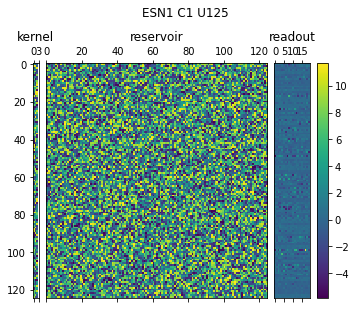

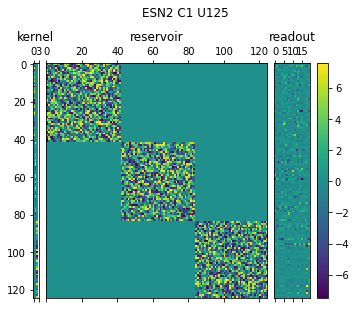

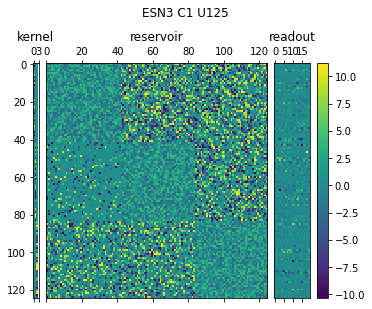

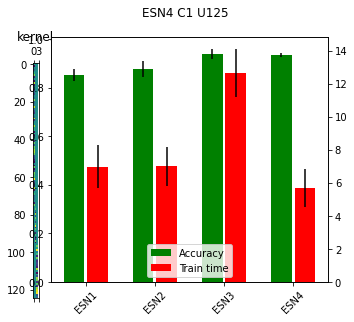

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U150 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U150 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.5361 - accuracy: 0.8350
Results:
	Accuracy: 85.81±1.56%
	Loss: 0.46±0.05
	Time: 6.19±0.17s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U150 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U150 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.3032 - accuracy: 0.9032
Results:
	Accuracy: 90.03±2.43%
	Loss: 0.31±0.06
	Time: 6.46±0.70s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U150 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U150 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7616445093720043, 0.7279399459838641], [0.2181885406208406, 1.0, 0.6669088714383822], [0.5003397276012739, 0.5892722337879779, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.1988 - accuracy: 0.9561
[[1.0, 0.76164450

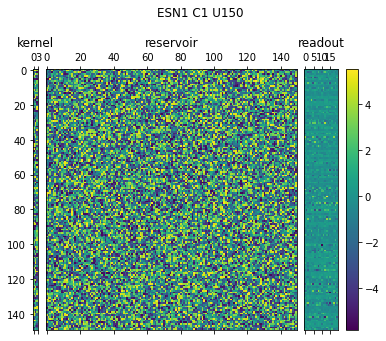

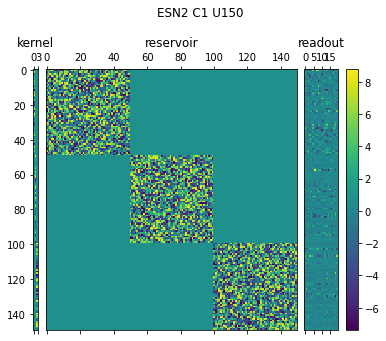

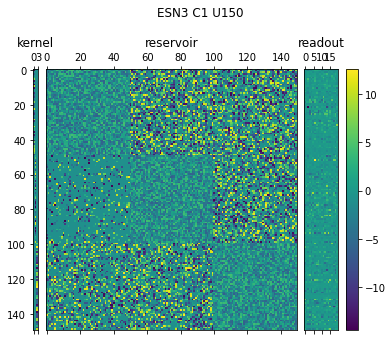

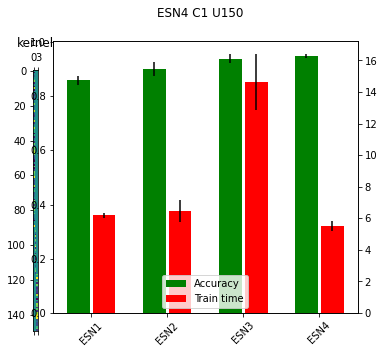

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U175 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U175 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.4416 - accuracy: 0.8614
Results:
	Accuracy: 86.85±2.49%
	Loss: 0.44±0.08
	Time: 6.81±1.47s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U175 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U175 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.5069 - accuracy: 0.8503
Results:
	Accuracy: 83.31±4.26%
	Loss: 0.57±0.12
	Time: 5.31±0.69s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U175 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U175 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.9592299068749687, 0.9333354024793468], [0.8558326097186789, 1.0, 0.5609390585691921], [0.11910853809243149, 0.5246594818160732, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.4698 - accuracy: 0.9394
[[1.0, 0.9592299

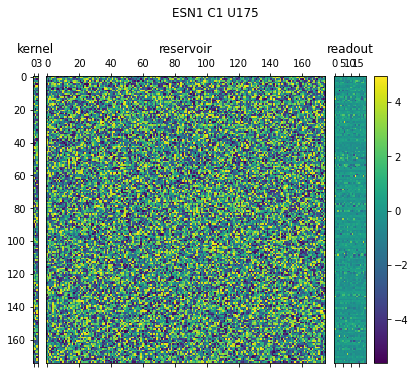

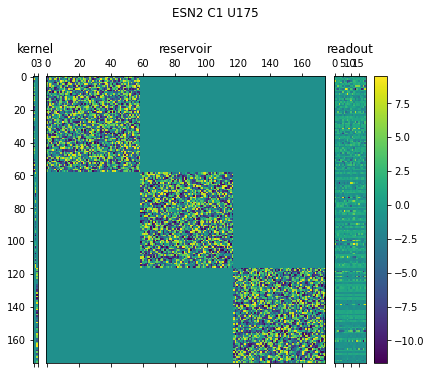

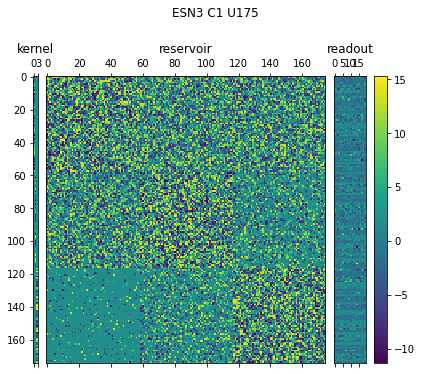

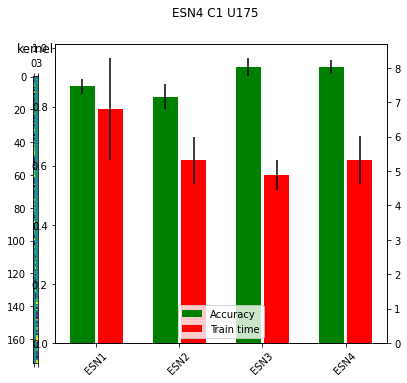

INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U200 hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN1 C1 U200 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.8489
Results:
	Accuracy: 87.49±2.33%
	Loss: 0.41±0.07
	Time: 6.91±0.43s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U200 hyperband/oracle.json


/dati/luca/Uni-Luca/Tesi/tesi/lib/utility.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN2 C1 U200 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
45/45 [==============================] - 0s 1ms/step - loss: 0.3389 - accuracy: 0.8969
Results:
	Accuracy: 90.74±2.49%
	Loss: 0.31±0.06
	Time: 6.39±0.85s
INFO:tensorflow:Reloading Oracle from existing project /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U200 hyperband/oracle.json
[[1.0, 0.1, 0.1], [0.1, 1.0, 0.1], [0.1, 0.1, 1.0]]
INFO:tensorflow:Reloading Tuner from /dati/luca/Uni-Luca/Tesi/tesi/models/tuner/character trajectories/ESN3 C1 U200 hyperband/tuner0.json
INFO:tensorflow:Oracle triggered exit
Start 5 benchmarks:
[[1.0, 0.7616445093720043, 0.7279399459838641], [0.2181885406208406, 1.0, 0.6669088714383822], [0.5003397276012739, 0.5892722337879779, 1.0]]
45/45 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.9422
[[1.0, 0.76164450

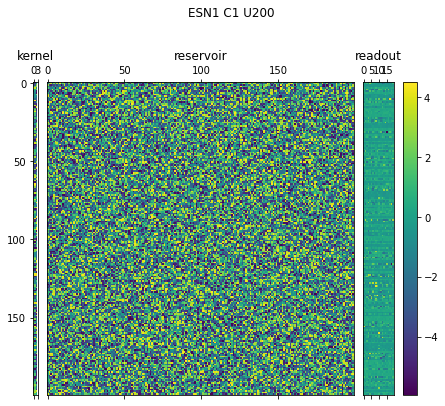

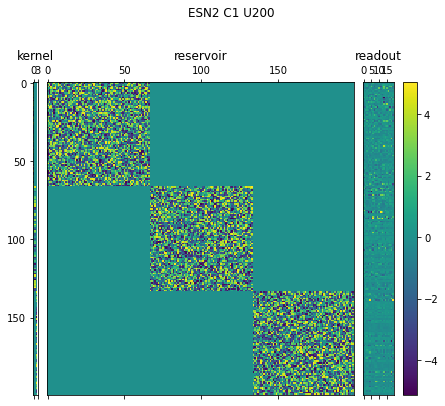

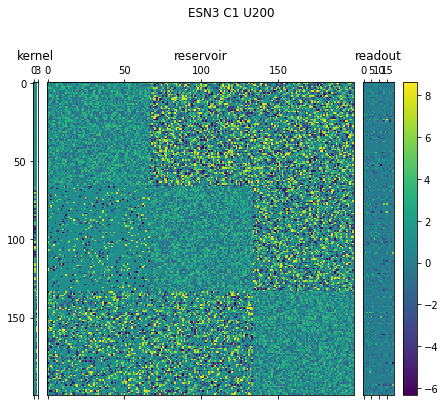

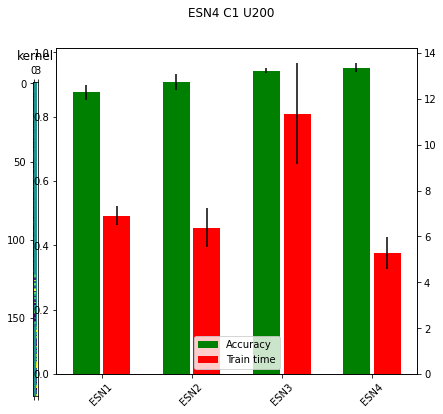

In [8]:
test = [25, 50, 75, 100, 125, 150, 175, 200]
build_models = [build_model_ESN1, build_model_ESN2, build_model_ESN3, build_model_ESN4]
model_names = ['ESN1 C1 U','ESN2 C1 U','ESN3 C1 U','ESN4 C1 U']
total_b = {}
for units in test:
    benchmarks = {}
    for build_fn, name in zip(build_models, model_names) :
        tf.random.set_seed(42)
        model_name = name + str(units)

        model = tune_and_test(model_name, build_fn, train_set, val_set, test_set, EPOCHS, PATIENCE, GUESSES, benchmarks,
                              tuner_path=TUNER_DIR)

        matrices = [tf.transpose(model.reservoir.layers[1].cell.kernel),
                    model.reservoir.layers[1].cell.recurrent_kernel,
                    model.readout.layers[0].weights[0]]

        plot_matrices(matrices, model_name, IMAGE_DIR)

    plot_benchmarks(units, benchmarks, IMAGE_DIR)
    copy = dict(benchmarks)
    total_b.update(copy)

In [16]:
f = open(os.path.join(PROJECT_ROOT, "data/benchmarks.txt"), "a")
for b in total_b.values():
    f.write(str(b)+'\n\n')
f.close()